## Uninteresting Example
Running the particle filter on real flu data. 

However, we don't have anything to compare it to, as the Trend Forecasting is not in place yet.

In [1]:
from src import run_particle_filter

run_particle_filter.main(
    location_code="04", target_date="2023-10-28", num_particles=100
)

Error loading state populations: name 'config' is not defined


NameError: name 'config' is not defined

In [ ]:
"""Plotting"""

import seaborn as sns
import pandas as pd

df = pd.read_csv("../output/pf_avg_betas/04/2023-10-28_avg_betas.csv", header=None)
df.rename(columns={0: "pf_avg_beta"}, inplace=True)
list(df.columns)

In [ ]:
sns.lineplot(data=df)

## Integrating the PF with SPHERE

I installed SPHERE as a package using PIP. 
I hard-coded beta as a constant 0.2. Not seen below. 

In [4]:
from sphere.model.model_factory import ModelFactory
from sphere.parameters.parameters import SIRHParameters
from sphere.solvers.implementations import EulerSolver

days = 150
params = SIRHParameters()
sirh = ModelFactory.create_model(
    model_type="SIRH", params=params, solver_cls=EulerSolver
)
az_population = 7151502
sirh.run(
    x0=[az_population * 0.98, az_population * 0.02, 0, 0, 0],
    t0=0,
    t_final=days - 1,
    dt=1.0,
)

Running Model: 100%|██████████| 149/149 [00:00<00:00, 335.88it/s]

Model.run() was successful. Data is accessible at Model.output.states. Plot the output with Model.output.plot_states().


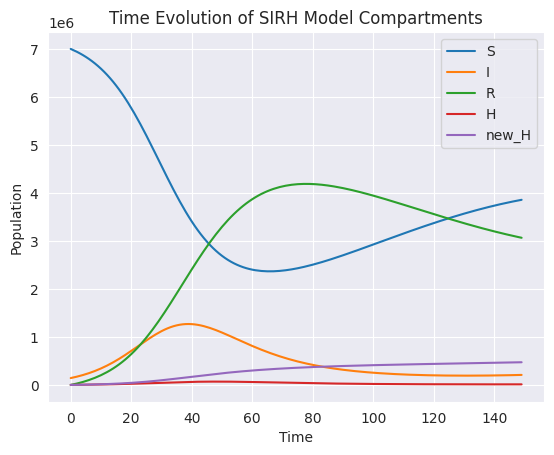

In [5]:
sirh.output.plot_states()

In [6]:
sirh.output.observations.shape
sirh.output.observations

Array([ 858.1803,  940.5656, 1030.1226, 1127.3295, 1232.6669, 1346.6111,
       1469.6249, 1602.1476, 1744.5839, 1897.2891, 2060.555 , 2234.5913,
       2419.509 , 2615.2998, 2821.8154, 3038.7483, 3265.6125, 3501.7253,
       3746.1924, 3997.899 , 4255.5034, 4517.4385, 4781.9214, 5046.9707,
       5310.4336, 5570.0195, 5823.345 , 6067.984 , 6301.5225, 6521.619 ,
       6726.0625, 6912.8296, 7080.1367, 7226.4824, 7350.6855, 7451.9033,
       7529.647 , 7583.7773, 7614.495 , 7622.3184, 7608.0513, 7572.747 ,
       7517.67  , 7444.249 , 7354.035 , 7248.663 , 7129.809 , 6999.158 ,
       6858.372 , 6709.0635, 6552.7783, 6390.975 , 6225.016 , 6056.1587,
       5885.55  , 5714.226 , 5543.114 , 5373.032 , 5204.6973, 5038.7285,
       4875.6533, 4715.9155, 4559.8813, 4407.848 , 4260.0493, 4116.6606,
       3977.8098, 3843.579 , 3714.0127, 3589.122 , 3468.8896, 3353.2732,
       3242.211 , 3135.624 , 3033.4192, 2935.4922, 2841.7305, 2752.015 ,
       2666.2212, 2584.2217, 2505.8877, 2431.0889, 

In [7]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=az_population,
    location_code="04",
    target_date="2047-10-28",
    runtime=days,
    likelihood_r=10,
    likelihood_p=0.3,
)

In [8]:
observations = sirh.output.observations.tolist()
observations = [round(obs) for obs in observations]

In [9]:
betas, _, states, all_resamples, all_weights = pf_algo.run(
    observation_data=observations
)

Running Particle Filter: 100%|██████████| 150/150 [03:15<00:00,  1.30s/it]


In [7]:
import numpy as np

generated_data = sirh.output.states
all_data = np.zeros((days, 6))
all_data[:, 0:5] = generated_data
all_data[:, 5] = [0.2 for _ in range(days)]

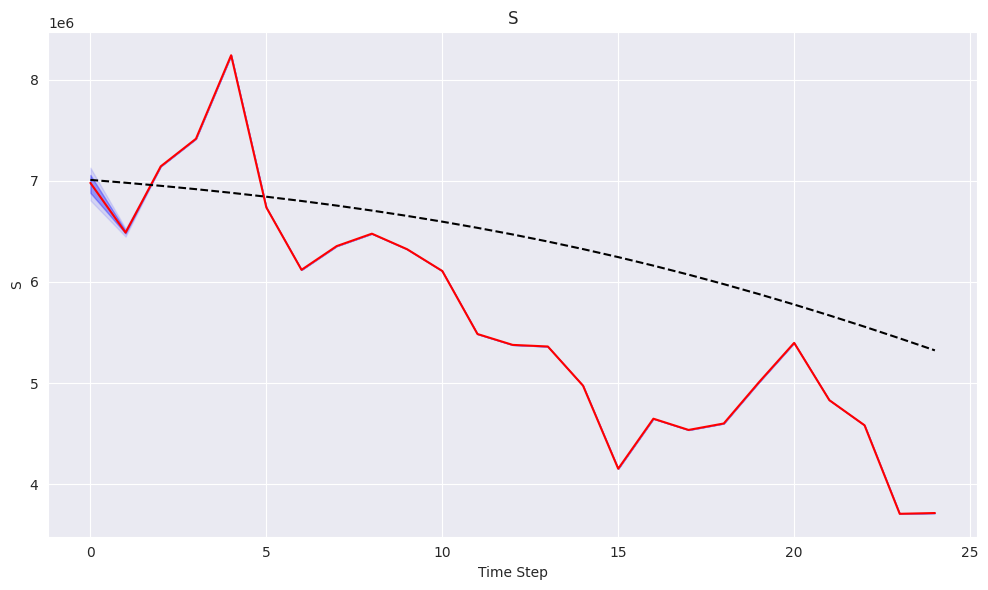

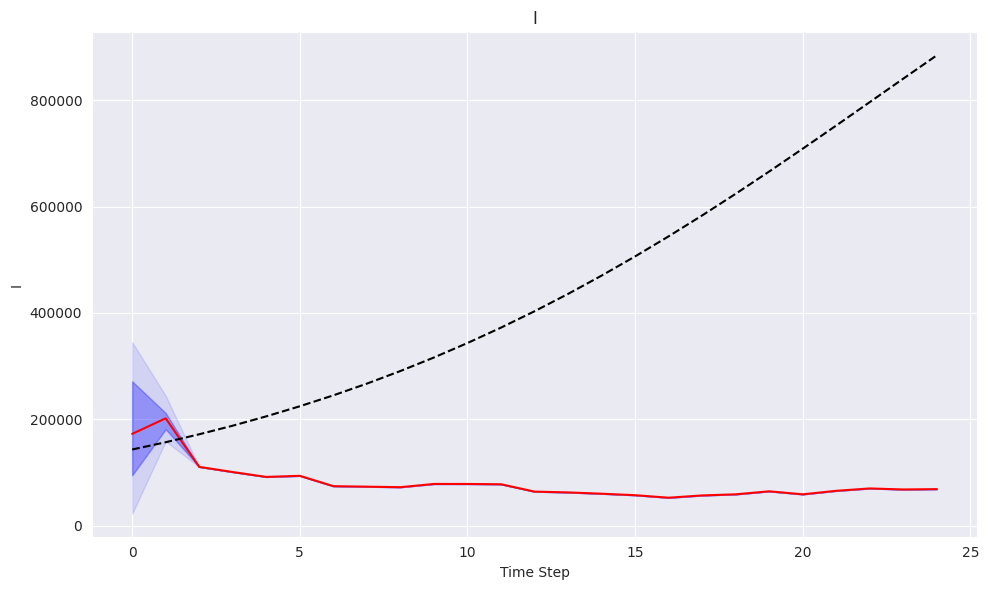

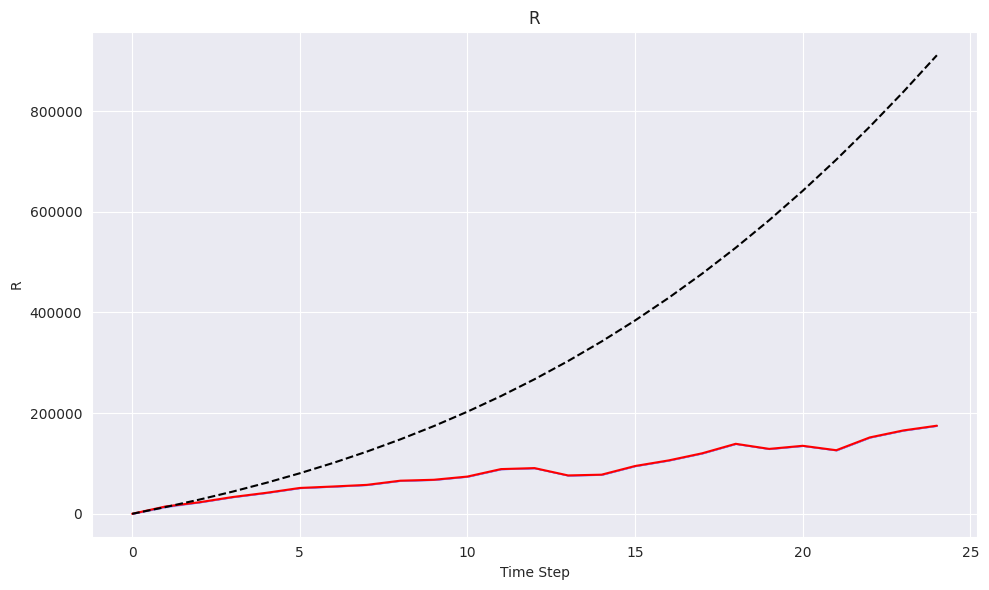

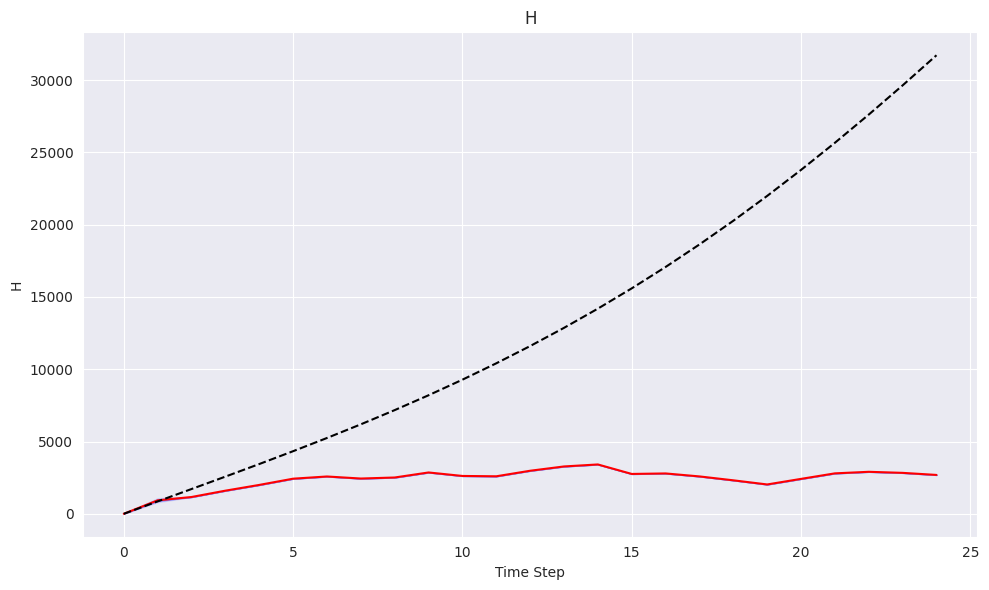

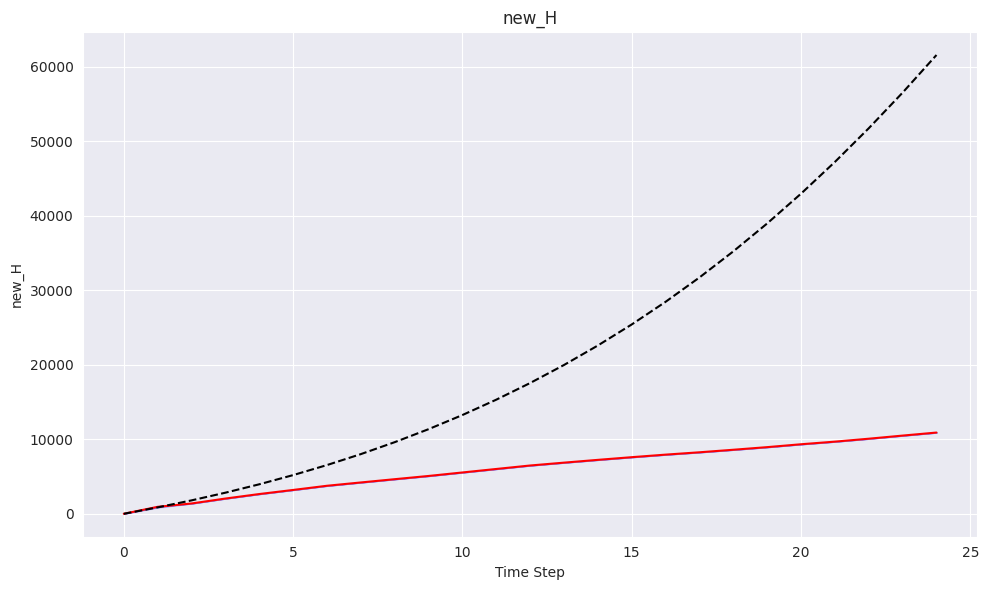

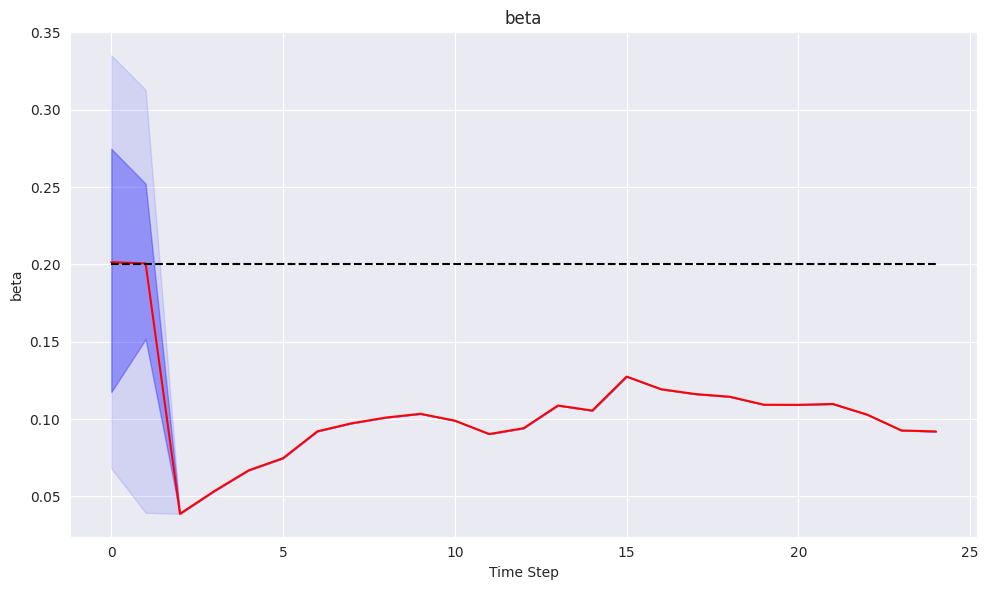

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Number of particles, state variables, and time steps
N, S, T = states.shape

state_labels = ["S", "I", "R", "H", "new_H", "beta"]

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

# Plot each state variable separately
for i in range(S):
    data = states[:, i, :]  # Shape (N, T)

    quantile_values = np.percentile(data, [q * 100 for q in quantiles], axis=0)

    plt.figure(figsize=(10, 6))

    # Fill areas between quantiles
    plt.fill_between(
        np.arange(T), quantile_values[0], quantile_values[-1], color="blue", alpha=0.1
    )
    plt.fill_between(
        np.arange(T), quantile_values[1], quantile_values[-2], color="blue", alpha=0.3
    )
    plt.plot(np.arange(T), quantile_values[2], color="red")  # Median
    plt.plot(np.arange(T), all_data[:, i], color="black", linestyle="--")  # true data

    plt.title(state_labels[i])
    plt.xlabel("Time Step")
    plt.ylabel(state_labels[i])

    plt.tight_layout()
    plt.show()
    plt.close()

In [9]:
states.shape

(250, 6, 25)

In [10]:
import jax.numpy as jnp

unique_betas = jnp.unique(states[:, 5, 50])
unique_betas

Array([0.09203633], dtype=float32)

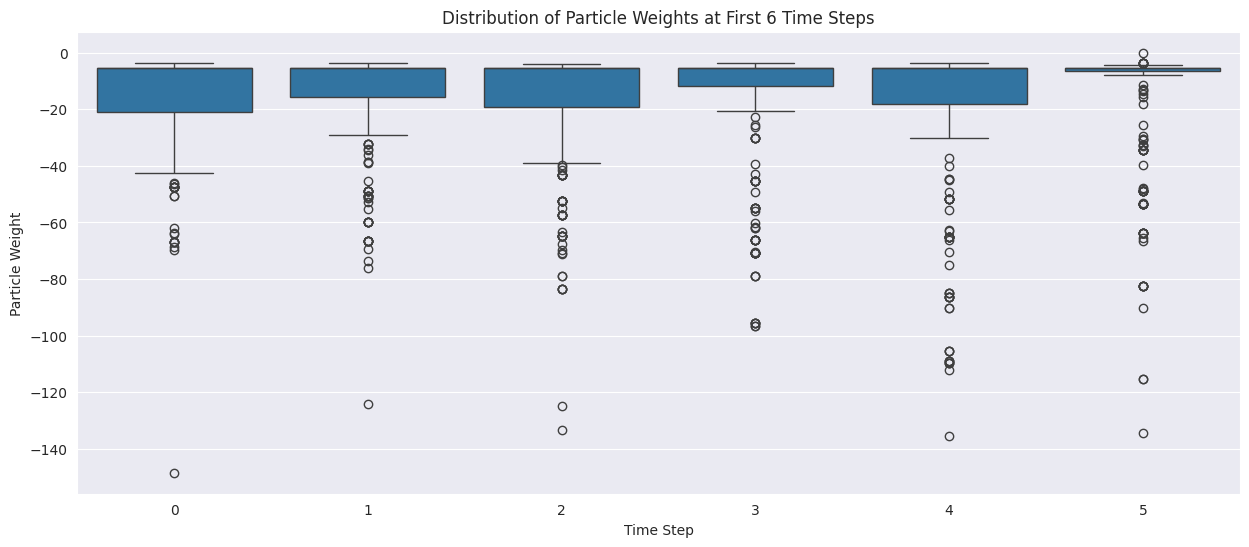

In [11]:
T = 6  # Number of time steps

first_five_weights = all_weights[:, 0:T]
# Create a DataFrame for seaborn
import pandas as pd

data = {"Weight": first_five_weights.flatten(), "Time Step": np.repeat(np.arange(T), N)}
df = pd.DataFrame(data)

# Create a box plot
plt.figure(figsize=(15, 6))
sns.boxplot(x="Time Step", y="Weight", data=df)
plt.title(f"Distribution of Particle Weights at First {T} Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Particle Weight")
plt.show()

In [16]:
from scipy.stats import nbinom, norm

norm(loc=0.06, scale=0.01).rvs(3)

array([0.06716053, 0.06438222, 0.06455921])